# Introduction

This notebook shows a very simple pipeline to explore a phone sensors dataset ("Physical Activity Recognition Dataset Using Smartphone Sensors") from http://ps.ewi.utwente.nl/Datasets.php, and develop and test a ML algorithm to predict the type of physical activity the user is engaging in.

### Results
We claim a 96% accuracy with a properly (and realistically) trained random forest *multiclass* and *multioutput* classifier.


## Imports: with hindsight of course...

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputClassifier

# Data Exploration

In [2]:
!ls Activity_Recognition_DataSet

Arm.xlsx    Belt.xlsx   Pocket.xlsx Readme.txt  Wrist.xlsx


In [4]:
df_arm=pd.read_excel("Activity_Recognition_DataSet/Arm.xlsx")
df_pocket=pd.read_excel("Activity_Recognition_DataSet/Pocket.xlsx")
df_wrist=pd.read_excel("Activity_Recognition_DataSet/Wrist.xlsx")
df_belt=pd.read_excel("Activity_Recognition_DataSet/Belt.xlsx")

Let me report here some of the readme content

## 1 Data Collection Procedure 

We used four Samsung Galaxy S2 smartphones in our experiments for data collection. Using these smartphones, we collected data for six different physical activities. They are walking, running, sitting, standing, walking upstairs and downstairs. We asked four participants to perform these six activities for a few minutes. As these are repetitive activities, so the amount of time for each activity was kept between 3-5 minutes per participant which gave us enough examples for our evaluations. The activities were carried out indoor in one of our university buildings. For walking, and running, the department's corridor was used. For sitting activity, participants’ offices were used when they were using their computers. For standing activity, coffee area was used where some participants stood for few minutes while involved in a conversation with others. For walking upstairs and downstairs, 5-floor stairs were used. It is important to mention that these stairs had short walks at each floor for switching between stairs (2-3 steps) but there were only four such switches in the whole walking upstairs and downstairs activities. We could not find one single continuous stair from first till 5th floor. Each of these participants was provided with four smartphones on four body positions: right jeans pocket, belt, arm, and wrist. The data was recorded for all four positions at the same time for each activity. All the four participants were male, between the age of 25 and 30. They signed a consent form before taking part in the activities

In [4]:
df_arm.head()

Time_Stamp         Ax         Ay        Az        Gx        Gy  \
0  1364396345335 -17.365944  19.517958  0.885323 -0.121868  2.177429   
1  1364396345354  -9.684067  13.933616  1.157730 -0.053145 -1.751656   
2  1364396345375  -4.045243   7.709117 -1.266692 -0.596510 -3.471852   
3  1364396345394  -1.770645   5.788648 -0.735499 -0.867734 -2.983771   
4  1364396345414   2.819412   3.963521  0.599295 -0.541227 -2.662762   

         Gz         Mx         My        Mz Activity_Label  
0  1.535715  18.300000 -44.160000  8.639999     Downstairs  
1  1.254106  17.279999 -44.160000  9.179999     Downstairs  
2  1.176526  16.500000 -44.399998  9.360000     Downstairs  
3  0.893696  15.900000 -44.520000  9.360000     Downstairs  
4  0.328645  15.000000 -44.700000  9.240000     Downstairs

ok let's see the descriptions

In [15]:
df_arm.describe()

Time_Stamp             Ax             Ay             Az  \
count  1.606550e+05  160655.000000  160655.000000  160655.000000   
mean   1.364371e+12      -0.275081       8.763833       2.281637   
std    4.265402e+07       4.576472       4.180374       2.368637   
min    1.364300e+12     -19.517958      -7.709117     -14.873420   
25%    1.364310e+12      -1.906849       7.055340       0.885323   
50%    1.364398e+12       0.122583       8.798744       2.138395   
75%    1.364400e+12       1.838747      10.065437       3.854558   
max    1.364403e+12      19.531578      19.599680      19.381754   

                  Gx             Gy             Gz             Mx  \
count  160655.000000  160655.000000  160655.000000  160655.000000   
mean        0.006953       0.035258      -0.014379       0.291451   
std         0.501906       1.292655       1.260051      17.396151   
min        -3.382361      -6.743647      -7.708508     -46.739998   
25%        -0.175624      -0.327424      -0.440281     -13.259999   
50%        -0.000305      -0.000305       0.000916       0.720000   
75%         0.181732       0.370490       0.294132      11.639999   
max         3.577227       7.074431       8.998656      47.940000   

                  My             Mz  
count  160655.000000  160655.000000  
mean      -39.890499      -9.432653  
std         7.601236      14.301760  
min       -80.460000     -46.920000  
25%       -45.899998     -21.180000  
50%       -40.500000     -12.059999  
75%       -34.559998       2.220000  
max        23.400000      41.520000

## Comments:

Acceleration seems to be small on average on the arm unit's x axis and large on y and z. This would make sense if the sensor was mounted on the arm with the y axis, the most mobile, being perpendicular to the arm to the front of the person, the x axis being along the arm and the z axis perpendicular to the arm sticking sideways away from the person.

If this is true then the largest average value of the angular momentum should be around the y axis (rotation of the arm out and sideways) and practically vanishing around the x axis (a healthy arm can't spin around itself), which is also true!

Similar sanity checks shoud be considered for all sensors but for sake of time I'll put that off.


### 4 participants

I'm not sure how to distinguish between different participants, this might be an important confounding factor? (especially correlated with time stamps I suppose) I'll look at the time stamps and see if they cluster around four values maybe.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110c74358>]], dtype=object)

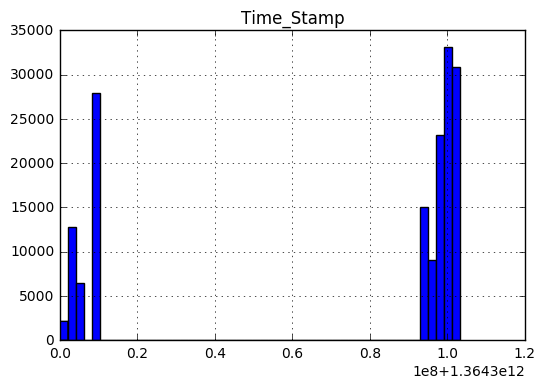

In [89]:
%matplotlib inline
df_arm.hist(column="Time_Stamp",bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x104636b70>]], dtype=object)

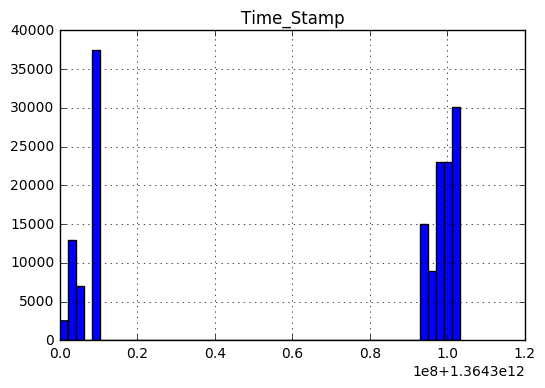

In [88]:
df_wrist.hist(column="Time_Stamp",bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111c22978>]], dtype=object)

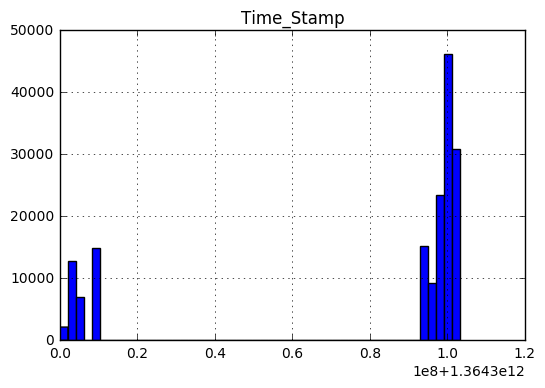

In [87]:
df_belt.hist(column="Time_Stamp",bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b036a0>]], dtype=object)

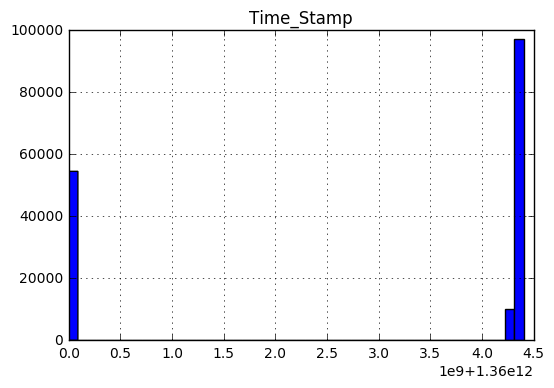

In [90]:
df_pocket.hist(column="Time_Stamp",bins=50)

## conclusions

ha! seems like there were 2 or more separate sessions here, this is worrisome because the time stamp variable might indeed identify two different subjects and therefore random cross validation might fail to recognize overfitting to the single user, i.e. a good performance might depend on the fact that the validation samples all belong to users that the model has already seen in training.

### choice: definitely leave the timestamp out of the features

### idea: try training on one session and validating on the other?
I have chosen not to explore this avenue in the interest of time

### Let's just have a look at the other sensors, shall we?
(btw, notice that the time stamp overlap is quite poor between different sensors)

In [273]:
df_wrist.describe()

Time_Stamp             Ax             Ay             Az  \
count  1.599920e+05  159992.000000  159992.000000  159992.000000   
mean   1.364365e+12       3.999756       6.272815       3.556179   
std    4.454557e+07       4.864204       6.496013       3.958921   
min    1.364300e+12     -19.449856     -19.531578     -19.381754   
25%    1.364310e+12       1.607201       0.544814       1.348414   
50%    1.364397e+12       3.200782       7.913422       3.119060   
75%    1.364400e+12       5.094010      10.569390       5.843129   
max    1.364403e+12      19.599680      19.613300      19.517958   

                  Gx             Gy             Gz             Mx  \
count  159992.000000  159992.000000  159992.000000  159992.000000   
mean       -0.000167      -0.035086       0.008984     -17.389723   
std         1.231178       1.191429       1.699583      17.302953   
min        -6.582073      -9.993755      -9.983676    -106.320000   
25%        -0.398590      -0.402255      -0.551306     -30.720000   
50%        -0.017410      -0.002749       0.006109     -19.560000   
75%         0.406836       0.347888       0.577879      -5.100000   
max         7.928114       9.727418       9.364870      47.160000   

                  My             Mz  
count  159992.000000  159992.000000  
mean      -18.429510     -17.693433  
std        16.664524      17.887243  
min       -62.579998     -78.000000  
25%       -30.779999     -34.260000  
50%       -22.140000     -20.039999  
75%        -8.520000      -4.020000  
max        46.320000     102.180000

In [49]:
df_pocket.describe()

Time_Stamp             Ax             Ay             Az  \
count  1.619580e+05  161958.000000  161958.000000  161958.000000   
mean   1.362913e+12      -0.344594      -8.066078      -2.552028   
std    2.074820e+09       3.651222       5.571840       5.155454   
min    1.360000e+12     -18.782460     -19.599680     -19.436235   
25%    1.360000e+12      -2.506144     -10.869038      -7.055340   
50%    1.364400e+12      -0.640156      -9.289077      -1.362035   
75%    1.364400e+12       1.838747      -2.260978       0.245166   
max    1.364401e+12      19.000385      19.122969      19.204690   

                  Gx             Gy             Gz             Mx  \
count  161958.000000  161958.000000  161958.000000  161958.000000   
mean        0.002540       0.038427      -0.036765       7.049494   
std         1.614946       1.409636       0.983442      16.293301   
min        -6.661180      -9.918008      -6.248846     -54.480000   
25%        -0.389045      -0.280082      -0.226936      -6.720000   
50%         0.009163       0.020769       0.009163       4.980000   
75%         0.718683       0.409280       0.279471      20.100000   
max         8.996212       9.972070       7.699040      84.000000   

                  My             Mz  
count  161958.000000  161958.000000  
mean       27.750156       7.739969  
std        15.571305      23.335165  
min       -14.940000     -52.980000  
25%        22.439999     -10.559999  
50%        29.820000      12.900000  
75%        39.899998      20.580000  
max        62.100000      56.579998

In [50]:
df_belt.describe()

Time_Stamp             Ax             Ay             Az  \
count  1.618070e+05  161807.000000  161807.000000  161807.000000   
mean   1.364378e+12       8.235560       1.570595      -1.520413   
std    3.923870e+07       5.514597       2.780470       3.153787   
min    1.364300e+12     -18.087822     -14.669114     -19.477097   
25%    1.364394e+12       7.150682      -0.503953      -2.901134   
50%    1.364399e+12       9.357179       1.579960      -1.253072   
75%    1.364400e+12       9.956474       3.064578      -0.258787   
max    1.364403e+12      19.586060      19.150210      14.601013   

                  Gx             Gy             Gz             Mx  \
count  161807.000000  161807.000000  161807.000000  161807.000000   
mean        0.025322       0.010226       0.006345     572.256849   
std         0.913859       1.264949       0.618870     581.389791   
min        -7.923228     -10.007805      -6.850243    -868.800000   
25%        -0.276111      -0.300851      -0.158825     -17.580000   
50%         0.021075       0.008858       0.008552     497.580000   
75%         0.239765       0.307876       0.136834    1250.580000   
max         9.956798       9.848675       6.445239    1360.380000   

                  My             Mz  
count  161807.000000  161807.000000  
mean     -131.268207     -68.937629  
std       131.999920      81.230263  
min      -409.620000    -317.340000  
25%      -270.300000    -116.340000  
50%       -93.720000     -82.500000  
75%       -18.720000      -1.800000  
max       163.560000     135.780000

## Might the dataset be unbalanced?

checking for balanced distribution of activities: OK!

In [39]:
for df in [df_arm,df_pocket,df_wrist,df_belt]:
    print("-------------")
    for i in set(df["Activity_Label"]):
        print(i,len(df[df["Activity_Label"]==i]))
    print("-------------")

-------------
Downstairs 18453
Sitting 30000
Walking 32001
Upstairs 21750
Running 28451
Standing 30000
-------------
-------------
Downstairs 19101
Sitting 30000
Walking 31252
Upstairs 22303
Running 29302
Standing 30000
-------------
-------------
Downstairs 18251
Sitting 29989
Walking 31451
Upstairs 21650
Running 28651
Standing 30000
-------------
-------------
Downstairs 18751
Sitting 30000
Walking 31751
Upstairs 21903
Running 29402
Standing 30000
-------------


## Let's create the data sets

In [54]:
time_stamp=False 
#this option will keep the time stamp within or without of the features, in case you want to check what happens
# when you include it, just toggle that to 'True'
init=1-int(time_stamp)
end=-4

x,y,y_loc=[],[],[]

for i,df in enumerate([df_wrist,df_arm,df_belt,df_pocket]):
    #x is a list of numpy arrays containing the features, the first 4 arrays have each one the contents from one 
    #different location, the fifth array has all the 4 arrays concatenated together
    x+=[np.array(df.iloc[:,init:end])]
    #y has the labels for the corresponding activities
    y+=[np.array(df.iloc[:,-1])]
    #y_loc has the labels (4) for location
    y_loc+=[[i]*len(df)]

x+=[np.concatenate(x)]
y+=[np.array(list(zip(np.concatenate(y_loc),np.concatenate(y))))]

Have a look at the datasets shapes to clarify what they are

In [31]:
#shapes of contents of x
[xx.shape for xx in x]

[(159992, 6), (160655, 6), (161807, 6), (161958, 6), (644412, 6)]

In [32]:
#shapes of contents of y
[yy.shape for yy in y]

[(159992,), (160655,), (161807,), (161958,), (644412, 2)]

## Let's now split test and train+validation sets

In [55]:
x_trainval,y_trainval=[],[]
x_test,y_test=[],[]

for xx,yy in zip(x,y):
    splittertemp = train_test_split(xx,yy,test_size=0.2)
    x_trainval+=[splittertemp[0]]
    x_test+=[splittertemp[1]]
    y_trainval+=[splittertemp[2]]
    y_test+=[splittertemp[3]]

In [22]:
def dataprep(time_stamp=False,magnetic=False):
    #this option will keep the time stamp within or without of the features, in case you want to check what happens
    # when you include it, just toggle that to 'True'
    init=1-int(time_stamp)
    if not magnetic:
        end=-4
    else:
        end=-1

    x,y,y_loc=[],[],[]

    for i,df in enumerate([df_wrist,df_arm,df_belt,df_pocket]):
        #x is a list of numpy arrays containing the features, the first 4 arrays have each one the contents from one 
        #different location, the fifth array has all the 4 arrays concatenated together
        x+=[np.array(df.iloc[:,init:end])]
        #y has the labels for the corresponding activities
        y+=[np.array(df.iloc[:,-1])]
        #y_loc has the labels (4) for location
        y_loc+=[[i]*len(df)]

    x+=[np.concatenate(x)]
    y+=[np.array(list(zip(np.concatenate(y_loc),np.concatenate(y))))]
    return x,y


def test_val_splitter(x,y,test_size=0.2,n_splits=8):
    
    x_trainval,y_trainval=[],[]
    x_test,y_test=[],[]
    for xx,yy in zip(x,y):
        splittertemp = train_test_split(xx,yy,test_size=test_size)
        x_trainval+=[splittertemp[0]]
        x_test+=[splittertemp[1]]
        y_trainval+=[splittertemp[2]]
        y_test+=[splittertemp[3]]
        
    x_train,y_train=[],[]
    x_val,y_val=[],[]
    for x_trv,y_trv in zip(x_trainval,y_trainval):
        x_tr,y_tr=[],[]
        x_v,y_v=[],[]
        for train,val in KFold(n_splits=n_splits,shuffle=True).split(x_trv):
            x_tr+=[x_trv[train]]
            x_v+=[x_trv[val]]
            y_tr+=[y_trv[train]]
            y_v+=[y_trv[val]]
        x_train+=[x_tr]
        x_val+=[x_v]
        y_train+=[y_tr]
        y_val+=[y_v]
    return x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval

In [23]:
x,y=dataprep()

In [25]:
x_train,x_val,x_test,y_train,y_val,y_test,x_trainval,y_trainval=test_val_splitter(x,y)

In [28]:
aa=validator(x_train,x_val,y_train,y_val,n_estimators=10,max_depth=30)

Average validation accuracy for the activity classification task 0.876 +- 0.002
Average validation accuracy for the location classification task 0.959 +- 0.001


In [27]:
bb=tester(x_trainval,x_test,y_trainval,y_test,n_estimators=10,max_depth=20)

Average test accuracy for the activity classification task 0.868 +- 0.000
Average test accuracy for the location classification task 0.959 +- 0.000


## Let's now split train from (8-fold) validation sets

In [56]:
x_train,y_train=[],[]
x_val,y_val=[],[]

for x_trv,y_trv in zip(x_trainval,y_trainval):
    x_tr,y_tr=[],[]
    x_v,y_v=[],[]
    for train,val in KFold(n_splits=8,shuffle=True).split(x_trv):
        x_tr+=[x_trv[train]]
        x_v+=[x_trv[val]]
        y_tr+=[y_trv[train]]
        y_v+=[y_trv[val]]
    x_train+=[x_tr]
    x_val+=[x_v]
    y_train+=[y_tr]
    y_val+=[y_v]

### Now I'm gonna pick one data set (arm) and fit it, then validate on homogeneous data (arm) and on the other 3 datasets to see if the same variables work the same way across the different sensor locations

In [57]:
n=1 #0=wrist, 1=arm, 2=belt, 3=pocket

scores_0,scores_1,scores_2,scores_3=[],[],[],[]

for i in range(8):
    model=RandomForestClassifier(n_estimators=10)
    model.fit(x_train[n][i],y_train[n][i])
    scores_0+=[len(y_val[n][i][y_val[n][i]==model.predict(x_val[n][i])])/len(y_val[n][i])]
    scores_1+=[len(y_val[(n+1)%4][i][y_val[(n+1)%4][i]==model.predict(x_val[(n+1)%4][i])])/len(y_val[(n+1)%4][i])]
    scores_2+=[len(y_val[(n+2)%4][i][y_val[(n+2)%4][i]==model.predict(x_val[(n+2)%4][i])])/len(y_val[(n+2)%4][i])]
    scores_3+=[len(y_val[(n+3)%4][i][y_val[(n+3)%4][i]==model.predict(x_val[(n+3)%4][i])])/len(y_val[(n+3)%4][i])]
    #print(scores)
print("%.3f" %np.mean(scores_0),"+-","%.3f" %np.std(scores_0))
print("%.3f" %np.mean(scores_1),"+-","%.3f" %np.std(scores_1))
print("%.3f" %np.mean(scores_2),"+-","%.3f" %np.std(scores_2))
print("%.3f" %np.mean(scores_3),"+-","%.3f" %np.std(scores_3))

0.900 +- 0.002
0.148 +- 0.004
0.158 +- 0.009
0.470 +- 0.007


## conclusions
So it seems that the features are specific to each location (which makes a lot of sense since the sensor is NOT an inertial reference frame and therefore its readings translate through complex non linear transformations between different body positions), so same variables at different locations don't yield at all the same predictivity, i.e. *a different model needs to be trained at every location*.

## Multi-output!
I believe I should actually consider arm/wrist/etc. as target labels! Because the actual use case might have the user carry the phone at different body locations. So in the following what I do is try to fit a multi output classifier, predicting both location and activity.

N.B. a linear classifier here would stand no chance at all, because clearly the classifier will have some sort of "if -> then" structure that gives a totally different importance to the same feature at different locations. This is a highly non-linear boundary

In [268]:
scores_act=[]
scores_loc=[]
for i in range(8):
    model=RandomForestClassifier(n_estimators=20,random_state=1, criterion='gini', max_depth=None, 
                                 min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0, 
                                 max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, 
                                 bootstrap=True, oob_score=False, n_jobs=1, verbose=0, 
                                 warm_start=False, class_weight=None)
    multi_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_model.fit(x_train[4][i],y_train[4][i])
    scores_act+=[len(y_val[4][i][y_val[4][i][:,1]==multi_model.predict(x_val[4][i])[:,1]])/len(y_val[4][i])]
    scores_loc+=[len(y_val[4][i][y_val[4][i][:,0]==multi_model.predict(x_val[4][i])[:,0]])/len(y_val[4][i])]
print("Average validation accuracy for the activity classification task","%.3f" %np.mean(scores_act),"+-","%.3f" %np.std(scores_act))
print("Average validation accuracy for the location classification task","%.3f" %np.mean(scores_loc),"+-","%.3f" %np.std(scores_loc))

Average validation accuracy for the activity classification task 0.955 +- 0.001
Average validation accuracy for the location classification task 0.990 +- 0.000


## some functions
defining here a more automated validation/testing pipeline, bear with me

In [14]:
def validator(x_train,x_val,y_train,y_val,n_estimators=20,random_state=1, criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=2, 
     min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,bootstrap=True, 
     oob_score=False, n_jobs=1, verbose=0, warm_start=False, class_weight=None):    
    scores_act=[]
    scores_loc=[]
    for i in range(8):
        model=RandomForestClassifier(n_estimators=n_estimators,random_state=random_state, criterion=criterion, 
                                     max_depth=max_depth, min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf, 
                                     min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
                                     max_leaf_nodes=max_leaf_nodes,min_impurity_split=min_impurity_split,
                                     bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
                                     warm_start=warm_start,class_weight=class_weight)
        multi_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_model.fit(x_train[4][i],y_train[4][i])
        scores_act+=[len(y_val[4][i][y_val[4][i][:,1]==multi_model.predict(x_val[4][i])[:,1]])/len(y_val[4][i])]
        scores_loc+=[len(y_val[4][i][y_val[4][i][:,0]==multi_model.predict(x_val[4][i])[:,0]])/len(y_val[4][i])]
    print("Average validation accuracy for the activity classification task","%.3f" %np.mean(scores_act),"+-",
          "%.3f" %np.std(scores_act))
    print("Average validation accuracy for the location classification task","%.3f" %np.mean(scores_loc),"+-",
          "%.3f" %np.std(scores_loc))
    return np.mean(scores_act),np.std(scores_act),np.mean(scores_loc),np.std(scores_loc)

In [20]:
def tester(x_trainval,x_test,y_trainval,y_test,n_estimators=20,random_state=1, criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=2, 
     min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,bootstrap=True, 
     oob_score=False, n_jobs=1, verbose=0, warm_start=False, class_weight=None):    
    scores_act=[]
    scores_loc=[]
    model=RandomForestClassifier(n_estimators=n_estimators,random_state=random_state, criterion=criterion, 
                                max_depth=max_depth, min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, 
                                min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features,
                                max_leaf_nodes=max_leaf_nodes,min_impurity_split=min_impurity_split,
                                bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
                                warm_start=warm_start,class_weight=class_weight)
    multi_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_model.fit(x_trainval[4],y_trainval[4])
    scores_act+=[len(y_test[4][y_test[4][:,1]==multi_model.predict(x_test[4])[:,1]])/len(y_test[4])]
    scores_loc+=[len(y_test[4][y_test[4][:,0]==multi_model.predict(x_test[4])[:,0]])/len(y_test[4])]
    print("Average test accuracy for the activity classification task","%.3f" %np.mean(scores_act),"+-",
          "%.3f" %np.std(scores_act))
    print("Average test accuracy for the location classification task","%.3f" %np.mean(scores_loc),"+-",
          "%.3f" %np.std(scores_loc))
    return np.mean(scores_act),np.std(scores_act),np.mean(scores_loc),np.std(scores_loc)

Now let's tune the model searching the hyperparameter space

In [272]:
validator(n_estimators=40)

Average validation accuracy for the activity classification task 0.958 +- 0.001
Average validation accuracy for the location classification task 0.990 +- 0.000


In [60]:
validator(n_estimators=10)

Average validation accuracy for the activity classification task 0.876 +- 0.001
Average validation accuracy for the location classification task 0.959 +- 0.001


(0.87592550523602775,
 0.0013172474623605779,
 0.95917203436587717,
 0.00072698355904171402)

In [282]:
validator(n_estimators=60)

Average validation accuracy for the activity classification task 0.959 +- 0.001
Average validation accuracy for the location classification task 0.991 +- 0.000


## wonderful!! 
Ok I realize that this was not an exhaustive hyperparameter search but the computation load is so heavy and performance is good enough that I believe I can stop here and do the:
## Testing!

In [284]:
tester(n_estimators=60)

Average validation accuracy for the activity classification task 0.962 +- 0.000
Average validation accuracy for the location classification task 0.991 +- 0.000


(0.96205861129861969, 0.0, 0.99113149135262213, 0.0)

Again, one here would do a test splitting again and rerun the entire thing and average the testing result to quote a more representative figure but this should be good enough

## Possible Refinements

One could use time-series-like information to help the classification out. For example if I classify one event as "running" and this event is surrounded by events that say "walking", that might be a very good indicator that we should instead classify the event as "running", as well. Let me quickly do some further exploration to see what this looks like.

In [316]:
act_dict={'Walking':0,'Running':1,'Downstairs':2,'Upstairs':3,'Standing':4,'Sitting':5}

In [317]:
df_temp=pd.concat([df_arm["Time_Stamp"],df_arm["Activity_Label"].apply(lambda x:act_dict[x])],axis=1)

In [320]:
df_temp.head() #here I just transformed the labels to numerical so I can plot them

Time_Stamp  Activity_Label
0  1364396345335               2
1  1364396345354               2
2  1364396345375               2
3  1364396345394               2
4  1364396345414               2

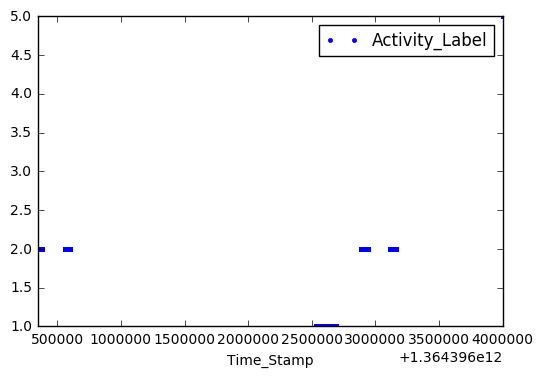

In [321]:
df_temp[:60000].plot(x="Time_Stamp", y="Activity_Label",style='.')

## Comment
The experimenter here separated the activities neatly in time. So a classification refinement should be absolutely trivial on this dataset (in other words, each misclassified sample is surrounded in time by a host of correctly classified samples)

However this might not serve as a good vaidation in a more realistic situation, where the user might switch somewhat smoothly between one activity and the other. (See recommendations below)

### More work: feature importance/correlation

Notice that I did not perform, again in the interest of time, any particular analysis of feature importance, correlation, etc.

Also, the algorithm I chose, random forest, is typically quite robust to this sort of problems.

# Conclusions
We can assert with some confidence that our model: a random-forest multi-output classifier with 60 estimators, properly trained, will classify new data with an accuracy of ~96%

# Recommendations to the experimenters for a more sound validation.

- Label data with user IDs as well.

- Label activities in a more fuzzy and flexible manner? (for example record a video of the users perform activities also transitioning from one to the other and use the video to label them)

In [15]:
df_pocket.tail(30)

Time_Stamp        Ax         Ay         Az        Gx        Gy  \
161928  1364300139420  0.340509 -10.651112  -2.533385  0.960586  0.200364   
161929  1364300139440  0.381370 -10.310603  -0.858082  0.865291  0.657902   
161930  1364300139460  0.095342 -10.446807   1.089628  0.723875  0.971581   
161931  1364300139480  0.708258 -11.931424  -0.081722 -0.198226 -0.254731   
161932  1364300139500 -0.789980 -14.641873  -3.187161 -0.520457 -0.655458   
161933  1364300139520 -2.669588 -14.464809  -3.200782 -0.392176 -0.524122   
161934  1364300139540 -1.893228 -14.573772  -3.949901 -0.545503  0.807258   
161935  1364300139560 -0.667397 -13.661209  -5.257454 -1.470047  1.573589   
161936  1364300139580 -0.231546 -12.448998  -5.584342 -2.410474  2.452624   
161937  1364300139600 -5.666065  -8.308413   1.702543 -3.339906  2.782491   
161938  1364300139620 -5.175732  -8.839605  10.419566 -2.950479  0.757167   
161939  1364300139640 -4.481094 -10.828176  11.223166 -2.002416 -0.339030   
161940  1364300139660 -5.992953 -16.249075  -5.911231 -2.778826 -0.273973   
161941  1364300139680 -6.156397 -16.575964  -4.276789 -2.531426 -0.752586   
161942  1364300139700 -4.535576 -11.890564   0.531194 -1.918117  1.002430   
161943  1364300139720 -2.901134  -8.322033  -0.054481 -1.506699  0.646601   
161944  1364300139740 -0.081722  -8.090487  -0.177065 -1.540602 -0.543365   
161945  1364300139760  1.089628  -8.580819  -0.394990 -1.577254 -1.159422   
161946  1364300139780 -0.708258  -6.333462   0.830841 -1.420262 -0.818559   
161947  1364300139800 -1.607201  -4.876084   1.253072 -1.482875 -0.885449   
161948  1364300139820 -2.601486  -2.547005   1.865988 -1.491122 -1.302365   
161949  1364300139840 -2.805792  -1.988571   2.220117 -1.331992 -1.796249   
161950  1364300139860 -2.928375  -1.797886   1.797886 -1.061684 -2.034792   
161951  1364300139880 -2.737690  -1.838747   0.994285 -0.600786 -2.068390   
161952  1364300139900 -2.724070  -1.988571   0.408610  0.050091 -1.798387   
161953  1364300139920 -2.601486  -4.426613  -2.369940  0.816727 -1.472491   
161954  1364300139940 -3.064578  -7.041720  -5.992953  1.326188 -1.075123   
161955  1364300139960 -4.903325 -15.363752 -14.900661  0.638049 -0.222966   
161956  1364300139980 -4.290410 -17.624730 -11.699879 -0.365603 -0.474948   
161957  1364300140000 -5.924851 -11.863323  -7.790839 -0.289245 -1.260826   

              Gz         Mx         My         Mz Activity_Label  
161928  0.176540  11.040000  31.080000 -18.000000        Walking  
161929 -0.071471  11.340000  30.660000 -19.199999        Walking  
161930 -0.285579  12.120000  29.880000 -21.000000        Walking  
161931  0.062003  12.420000  29.519999 -21.779999        Walking  
161932  0.315512  13.080000  28.859999 -23.279999        Walking  
161933  0.259923  13.200000  28.619999 -23.820000        Walking  
161934 -0.259923  13.679999  28.320000 -24.840000        Walking  
161935 -0.819781  13.920000  28.080000 -25.260000        Walking  
161936 -1.267240  14.099999  28.080000 -25.380000        Walking  
161937 -1.244027  14.639999  28.380000 -25.080000        Walking  
161938 -0.784045  14.820000  28.500000 -24.539999        Walking  
161939 -0.978912  14.820000  28.800000 -24.000000        Walking  
161940 -0.777021  14.580000  29.580000 -22.500000        Walking  
161941 -0.670730  14.400000  30.480000 -20.460000        Walking  
161942 -0.572992  14.040000  31.439999 -18.359999        Walking  
161943 -0.406836  13.500000  32.399998 -15.960000        Walking  
161944 -0.145691  12.960000  33.360000 -13.320000        Walking  
161945 -0.228769  12.300000  34.079998 -10.440000        Walking  
161946 -0.602313  11.759999  34.559998  -7.860000        Walking  
161947 -0.612392  11.400000  34.800000  -6.900000        Walking  
161948 -0.464868  10.740000  35.219997  -4.920000        Walking  
161949 -0.320093  10.380000  35.520000  -3.360000        Walking  
161950 -0.199753   9.719999  35.579998  -1.920000        Walking  
161951 -0.11117

In [23]:
def magnitude(df,ax,ay,az):
    return (df[ax].apply(lambda x:x**2)+df[ay].apply(lambda x:x**2)+df[az].apply(lambda x:x**2)).apply(lambda x:np.sqrt(x))

In [6]:
1364396345335/3600/24/365

43264.724293981475

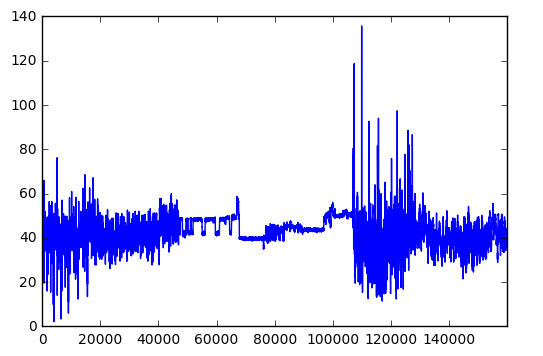

In [63]:
%matplotlib inline
magnitude(df_wrist,"Mx","My","Mz").plot()

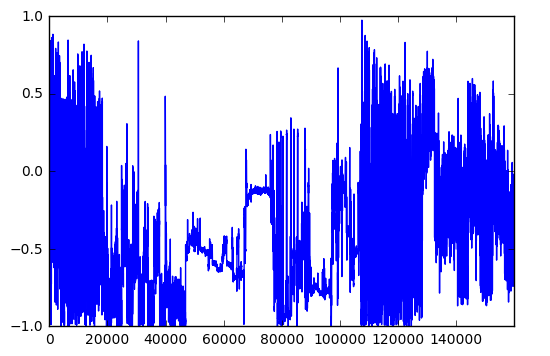

In [65]:
(df_wrist["Mx"]/magnitude(df_wrist,"Mx","My","Mz")).plot()